In [1]:
# standard cv libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# for reading of files
import glob

# gabor filter
from skimage.filters import gabor_kernel

# convolution operation
import scipy.signal as conv

Load test and template images

(3, 1000, 1000) (3, 1000, 1000)


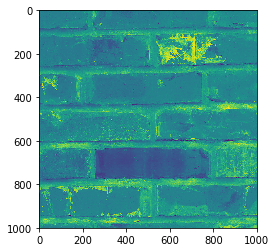

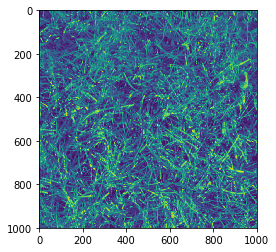

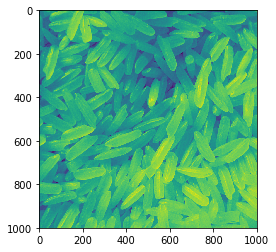

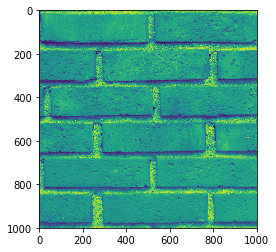

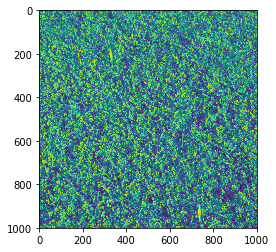

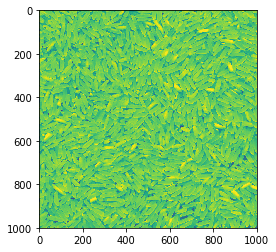

In [4]:
# read test images
filenames = [img for img in glob.glob("test_images/*.jpg")]
filenames.sort()

test_images = []
for img in filenames:
    im = cv2.imread(img)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    test_images.append(im)
    plt.figure()
    plt.imshow(im)
    
# read templates
filenames = [img for img in glob.glob("template_images/*.jpg")]
filenames.sort()

template_images = []
for img in filenames:
    im = cv2.imread(img)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    template_images.append(im)
    plt.figure()
    plt.imshow(im)

print(np.shape(test_images), np.shape(template_images))
im[2] = im[0]

Prepare gabor filter banks

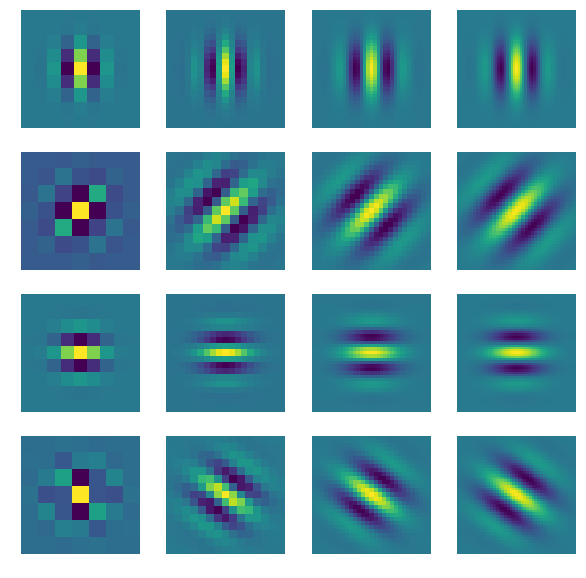

In [5]:
wavelengths = np.array([2, 5, 10, 15])
angles = np.array([0, 45, 90, 125])

# prepare filter bank kernels
filters = []
for angle in angles:
    for wavelength in wavelengths:
            filters.append(np.real(gabor_kernel(1/wavelength, theta=np.radians(angle))))
            
fig = plt.figure(figsize=(10, 10))
for i in range(16): 
    plt.subplot(4,4,i+1)
    plt.imshow(filters[i])
    plt.axis('off')

In [6]:
def compute_features(image, kernels):
    
    features = []
    for kernel in kernels:
        image_convolved = conv.convolve2d(image, kernel, mode='same')
        features.append(np.mean(image_convolved))
        features.append(np.var(image_convolved))
    
    return np.array(features)

def match_textures(image_features, templates_features):
    
    min_distance = np.inf
    min_match = 0
    for (i,template_features) in enumerate(templates_features):
        distance = np.linalg.norm(image_features - template_features)
        if(distance < min_distance):
            min_distance = distance
            min_match = i
    
    return min_match


Compute features for test and template images

In [7]:
test_features = []
template_features = []  
for test_image, template_image in zip(test_images, template_images):
    test_features.append(compute_features(test_image, filters))
    template_features.append(compute_features(template_image, filters))

Match textures

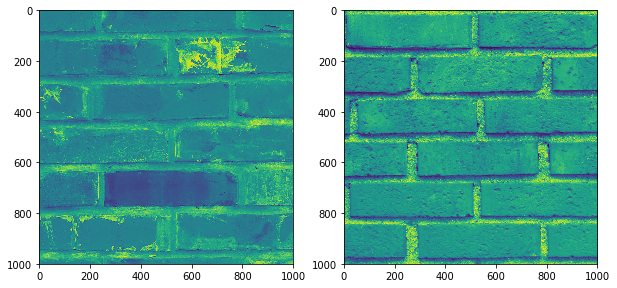

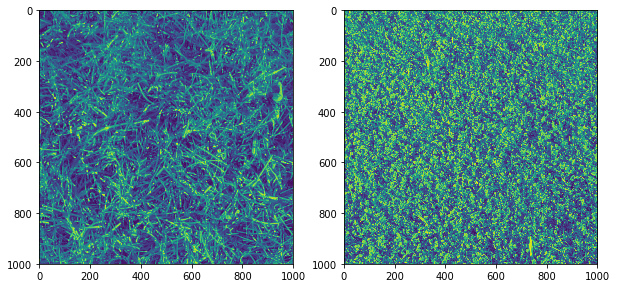

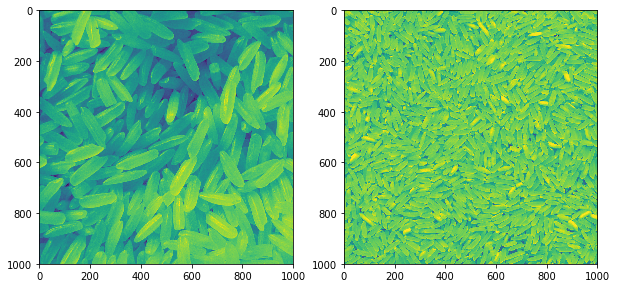

In [8]:
for (i,test_feature) in enumerate(test_features):
    best_match = match_textures(test_feature, template_features)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(test_images[i])
    plt.subplot(1,2,2)
    plt.imshow(template_images[i])

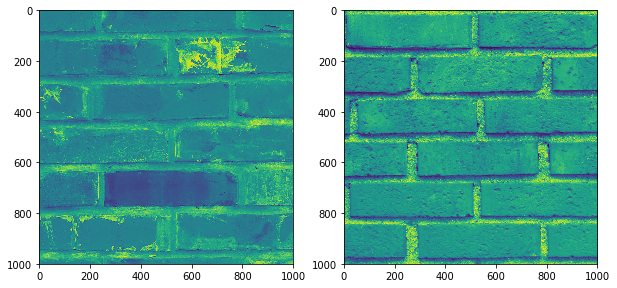

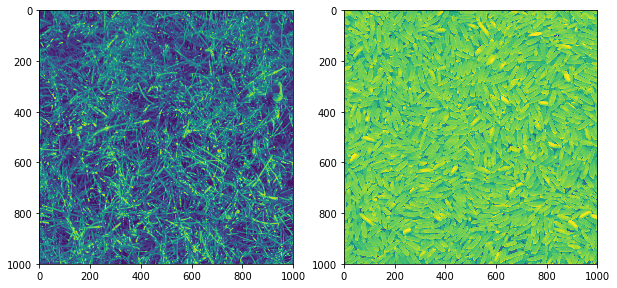

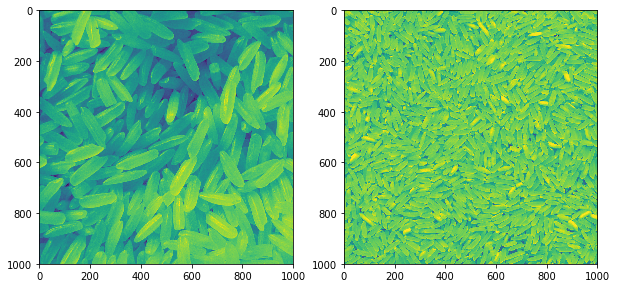

In [7]:
def compute_dft(image):   

    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum.flatten()
    
test_dft_features = []
template_dft_features = []
for test_image, template_image in zip(test_images, template_images):
    test_dft_features.append(compute_dft(test_image))
    template_dft_features.append(compute_dft(template_image))
    
for (i,test_feature) in enumerate(test_features):
    best_match = match_textures(test_feature, template_features)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(test_images[i])
    plt.subplot(1,2,2)
    plt.imshow(template_images[best_match])

Compute GLCM

In [ ]:
from skimage.feature import greycomatrix

# P[i,j,d,theta]
t = greycomatrix(np.uint8(np.round(np.multiply(7,test_images[0]/np.amax(test_images[0])))), [0], [0], levels=8)[:,:,0,0]

In [ ]:
from skimage.feature import greycomatrix

def co_occurrence_features(image, offset):
    
    # compute gray level co-occurrence matrix
    glcm = greycomatrix(np.uint8(np.round(np.multiply(7,image/np.amax(image)))), [offset], [0], levels=8, normed=True)[:,:,0,0]
    
    contrast = 0;
    dissimilarity = 0;
    homogeneity = 0;

    for i in range(np.shape(glcm)[0]):
        for j in range(np.shape(glcm)[1]):
            contrast = contrast + glcm[i,j]*(i-j)**2
            dissimilarity = dissimilarity + glcm[i,j]*np.abs(i-j)
            homogeneity = homogeneity + glcm[i,j]/(1+(i-j)**2)
    
    energy = np.sum(np.power(glcm,2))
    entropy = -np.sum(np.multiply(glcm, np.log(glcm+1e-5)))
        
    return np.array([contrast, dissimilarity, homogeneity, energy, entropy])

test_glcm_features = []
template_glcm_features = []
for test_image, template_image in zip(test_images, template_images):
    test_glcm_features.append(co_occurrence_features(test_image, 0))
    template_glcm_features.append(co_occurrence_features(template_image, 0))
    
for (i,test_feature) in enumerate(test_glcm_features):
    best_match = match_textures(test_feature, template_glcm_features)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(test_images[i])
    plt.subplot(1,2,2)
    plt.imshow(template_images[best_match])